# Time Series Model for [PROJECT NAME] Using Exponential Smoothing Version 1
### David Lowe
### September 30, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/

SUMMARY: [Sample Paragraph - The purpose of this project is to construct a time series prediction model using the exponential smoothing (ETS) technique and document the end-to-end steps using a template. The [PROJECT NAME] dataset is a time series situation where we are trying to forecast future outcomes based on past data points.]

INTRODUCTION: [Sample Paragraph - The problem is to forecast the monthly number of airline passenger miles traveled in the United States. The dataset describes a time-series of miles (in millions) over 18 years (1960-1977), and there are 216 observations. We used the first 80% of the observations for training various models while holding back the remaining observations for testing the final model.]

ANALYSIS: [Sample Paragraph - The baseline prediction for the dataset resulted in an RMSE of 1.770. After performing a grid search for the most optimal parameters, the best ETS configuration processed the test dataset with an RMSE of 0.435, which was better than the baseline model as expected.]

CONCLUSION: For this dataset, the chosen ETS model achieved a satisfactory result and should be considered for further modeling.

Dataset Used: [Sample Paragraph - Monthly U.S Air Passenger Miles January 1960 through December 1977]

Dataset ML Model: Time series forecast with numerical attributes

Dataset Reference: Rob Hyndman and Yangzhuoran Yang (2018). tsdl: Time Series Data Library. v0.1.0. https://pkg.yangzhuoranyang./tsdl/.

A time series predictive modeling project genrally can be broken down into about five major tasks:

1. Define Problem and Acquire Data
2. Inspect and Explore Data
3. Test Data for Trend and Seasonal Factors
4. Fit and Evaluate Models
5. Finalize Model and Make Predictions

## Task 1: Define Problem and Acquire Data

In [1]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load Libraries

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import boto3
import pandas_datareader.data as web
from datetime import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if (notifyStatus): email_notify("ETS Task 1: Define Problem and Acquire Data has begun!"+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Acquire and Load the Data

Since the dataset is not current, this means that we cannot easily collect updated data to validate the model. Therefore, we will withhold a portion of the data towards the end from analysis and model selection. This very segment of data will be used to validate the final model.

In [10]:
startTimeScript = datetime.now()

In [11]:
# load the dataset and the necessary data structure
time_series = pd.read_csv('https://dainesanalytics.com/datasets/time-series-data-library/tsdl200.csv', index_col='idx', parse_dates=True)

# Load the dataset from the Federal Reserve Bank's FRED Database
# starting = datetime(1990, 1, 1)
# ending = datetime.now()
# fred_data = 'SMU06000007072251101'
# time_series = web.DataReader(fred_data, 'fred', starting, ending)
# time_series.rename(columns={fred_data: 'value'}, inplace=True)

# Sample code for subsetting the time-series data
# time_series = original_series['1986':'1990']

In [12]:
target_col = time_series.columns[0]
lower_bound = 'lower ' + target_col
upper_bound = 'upper ' + target_col
print('The target column of the time series is:', target_col)
print('The forecast boundary columns are:', lower_bound, '&', upper_bound)

The target column of the time series is: values
The forecast boundary columns are: lower values & upper values


In [13]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 1960-01-01 to 1977-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   values  216 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


In [14]:
time_series.head()

,values
idx,
1960-01-01,2.42
1960-02-01,2.14
1960-03-01,2.28
1960-04-01,2.50
1960-05-01,2.44


In [15]:
time_series.tail()

,values
idx,
1977-08-01,19.49
1977-09-01,15.61
1977-10-01,16.16
1977-11-01,14.84
1977-12-01,17.04


In [16]:
if (notifyStatus): email_notify("ETS Task 1: Define Problem and Acquire Data completed!"+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2: Inspect and Explore Data

In [17]:
if (notifyStatus): email_notify("ETS Task 2: Inspect and Explore Data has begun!"+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Summary Statistics of the Time Series Data

Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with.

In [18]:
# Summary statistics of time series
time_series.describe()

,values
count,216.000000
mean,8.327546
std,4.924629
min,1.820000
25%,3.505000
50%,7.100000
75%,12.902500
max,19.490000


### 2.b) Line Plot of the Time Series Data

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot can include:

* Whether the trend appears to be level around the mean
* Whether there appear to be any obvious outliers

The ARIMA(p,d,q) model requires three parameters and assumes that we are working with a stationary time series.

The ADF results should show that the test statistic value is smaller than the critical value at 5% if the time series is stationary. This suggests that we can reject the null hypothesis (i.e. a low probability that the result is a statistical fluke).

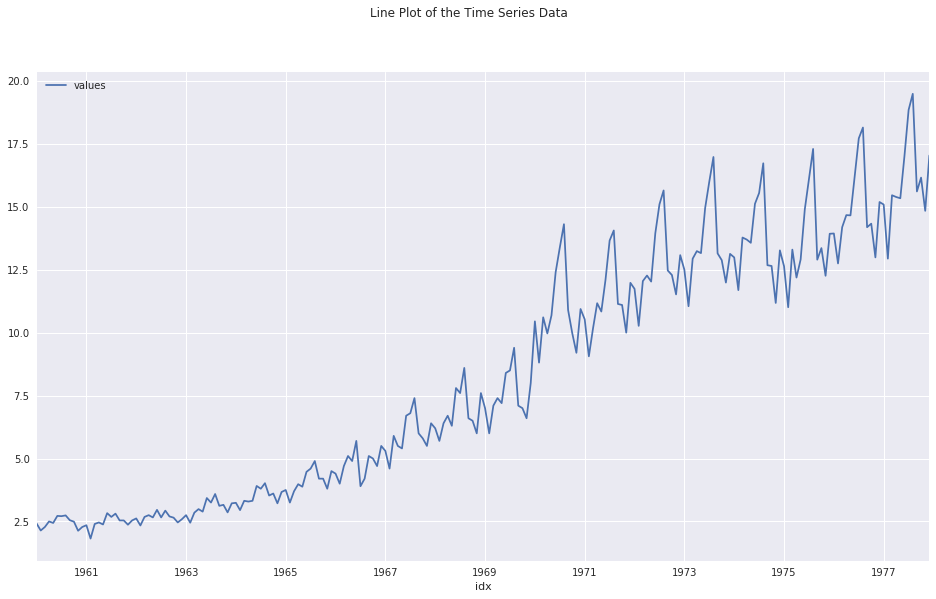

In [19]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(16,9))
fig.suptitle('Line Plot of the Time Series Data')
time_series.plot(ax=ax)
plt.show()

### 2.c) Histogram and Density Plots of the Time Series Data

Reviewing plots of the density of observations can provide further insight into the structure of the data. Some observations from the plots can include:

* Whether the distribution is Gaussian
* Whether the distribution has a long tail and may suggest the need for data transformation

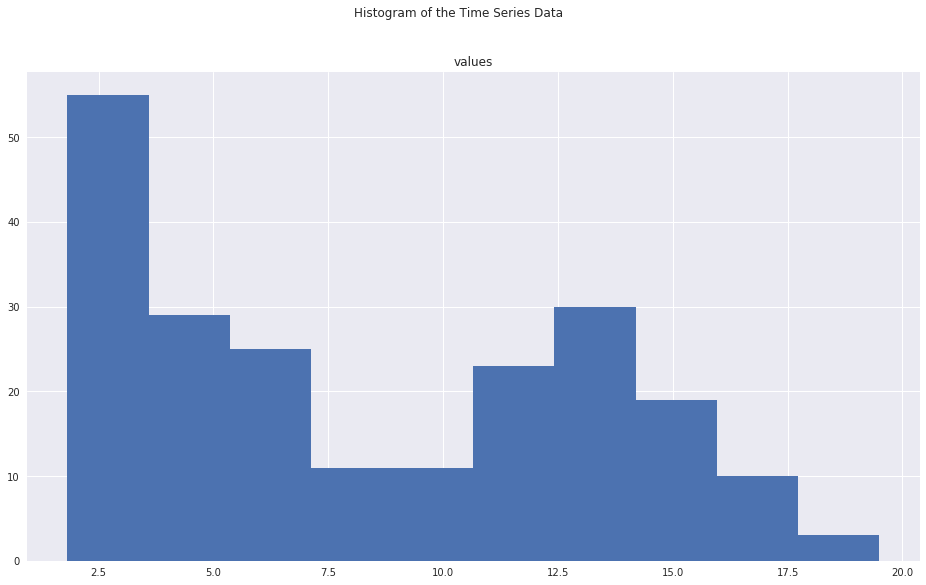

In [20]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(16,9))
fig.suptitle('Histogram of the Time Series Data')
time_series.hist(ax=ax)
plt.show()

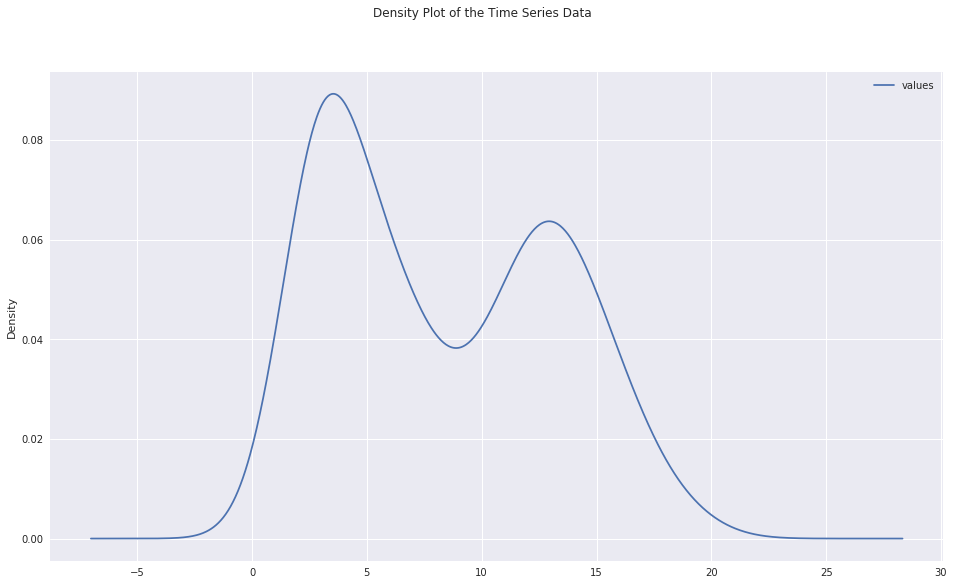

In [21]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(16,9))
fig.suptitle('Density Plot of the Time Series Data')
time_series.plot(kind='kde', ax=ax)
plt.show()

### 2.d) Box and Whisker Plots of the Time Series Data

We can group or aggregate the data and get a better idea of the spread of observations. Some observations from reviewing the plot can include:

* Whether the median values for each grouping shows any significant trend
* Whether the spread, or middle 50% of the data, shows any significant variability
* Whether there are outliers in some grouping

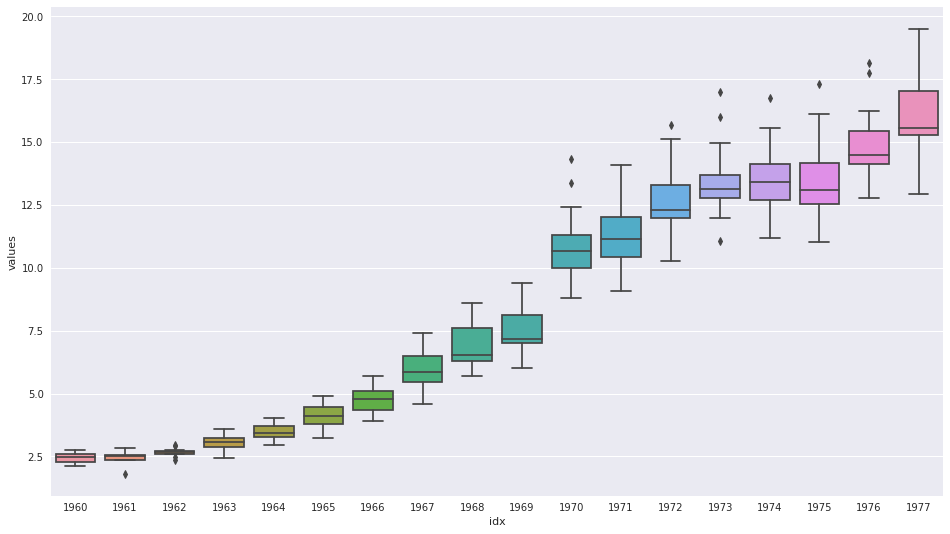

In [22]:
# boxplots of time series
fig, ax = plt.subplots(figsize=(16,9))
squeezed = time_series.squeeze()
sns.boxplot(squeezed.index.year, squeezed, ax=ax)
plt.show()

In [23]:
if (notifyStatus): email_notify("ETS Task 2: Inspect and Explore Data completed!"+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3: Test Data for Trend and Seasonal Factors

In [24]:
if (notifyStatus): email_notify("ETS Task 3: Test Data for Trend and Seasonal Factors has begun!"+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### Section 3.a) Data Transformation

In [25]:
# Resampling the time series into monthly average for the ease of modeling
# original_series = time_series
# resample = original_series.resample('M')
# time_series = resample.mean()
# time_series.head(10)

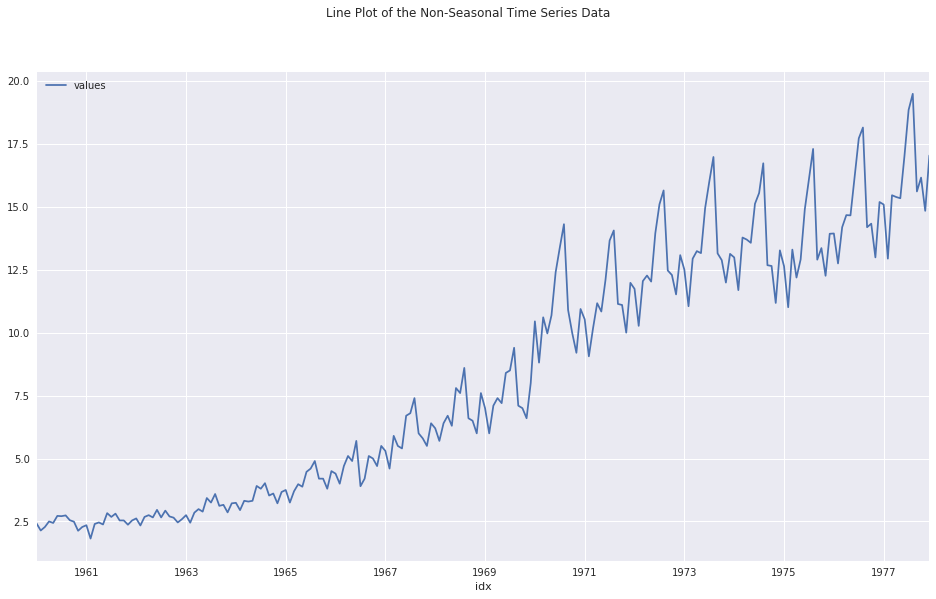

In [26]:
# Line plots of the transformed time series
fig, ax = plt.subplots(figsize=(16,9))
fig.suptitle('Line Plot of the Non-Seasonal Time Series Data')
time_series.plot(ax=ax)
plt.show()

### Section 3.b) Test for Stationarity

In [27]:
# Check if stationary
result = adfuller(time_series[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.315357
p-value: 0.978038
Critical Test Statistics Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


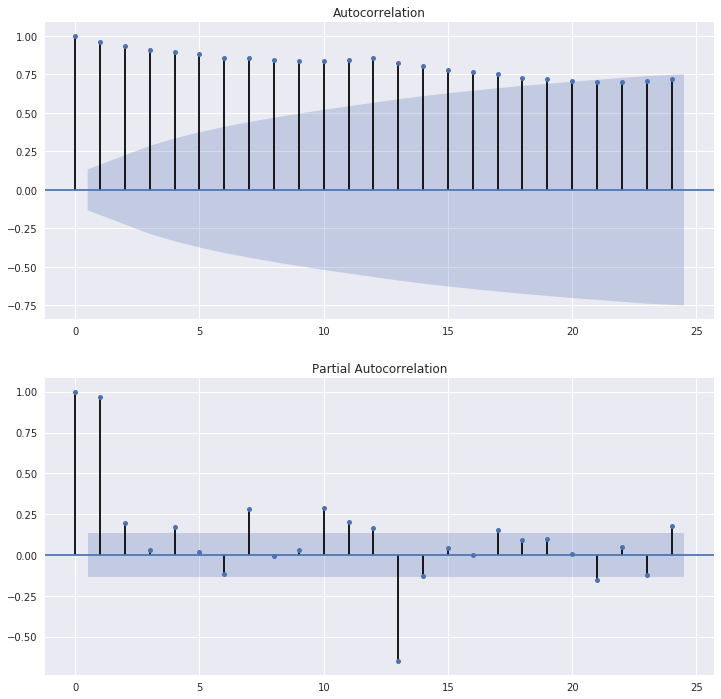

In [28]:
# ACF and PACF plots of the time series data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(time_series, ax=ax1)
plot_pacf(time_series, ax=ax2)
plt.show()

### 3.c) Test for Stationarity of Non-Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

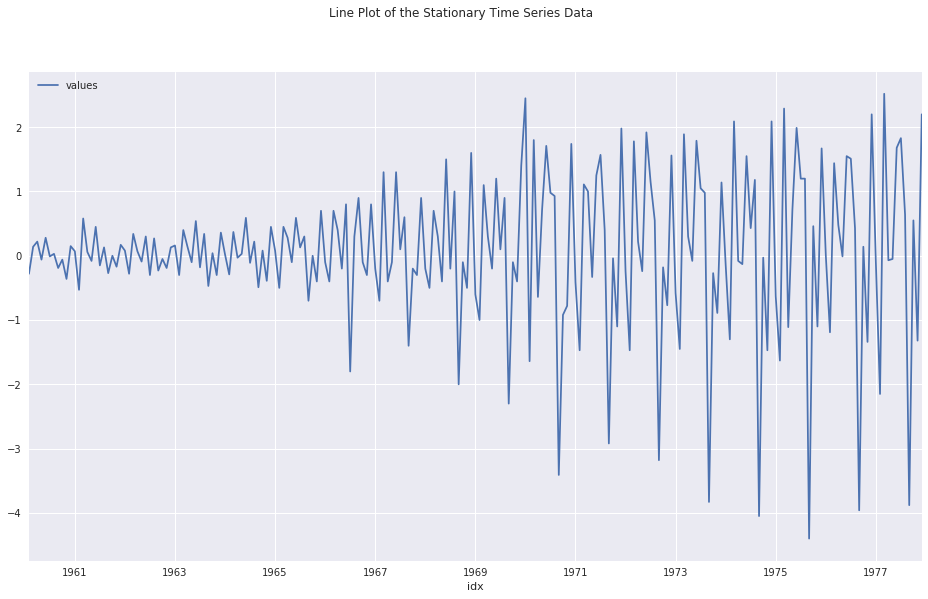

In [29]:
# Create a differenced series
stationary_ns = time_series.diff().dropna()

# Plot differenced data
fig, ax = plt.subplots(figsize=(16,9))
fig.suptitle('Line Plot of the Stationary Time Series Data')
stationary_ns.plot(ax=ax)
plt.show()

In [30]:
# Check for stationarity
result = adfuller(stationary_ns[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.748420
p-value: 0.003481
Critical Test Statistics Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


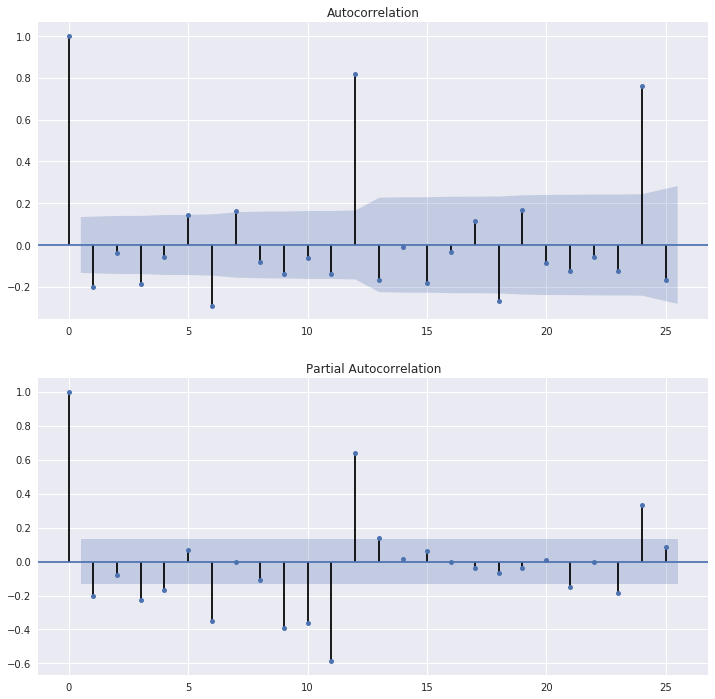

In [31]:
# ACF and PACF plots of the stationary time series
lags = 25
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ns, lags=lags, ax=ax1)
plot_pacf(stationary_ns, lags=lags, ax=ax2)
plt.show()

### 3.d) Seasonal Decomposition for Seasonal Time Series Data

In [32]:
# Set the initial seasonal frequency parameter
seasonal_freq = 12

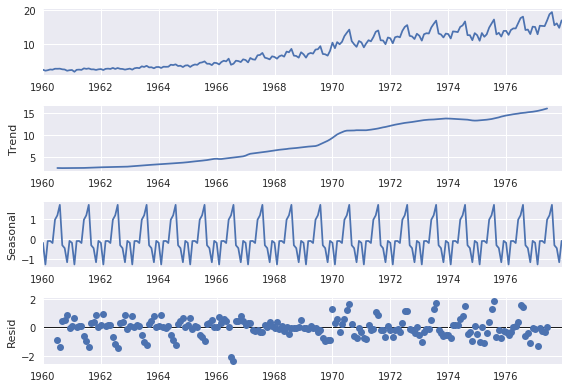

In [33]:
# Perform seasonal decomposition to observe the seasonal frequency
decomp_results = seasonal_decompose(time_series, period=seasonal_freq)
decomp_results.plot()
plt.show()

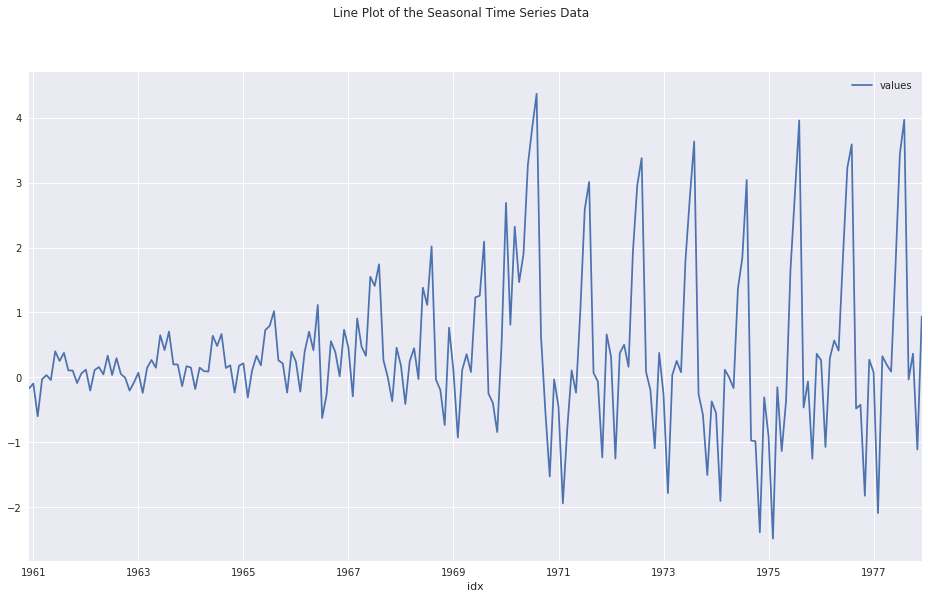

In [34]:
# Create a seasonal series
N = seasonal_freq
seasonal_series = time_series - time_series.rolling(N).mean()
seasonal_series = seasonal_series.dropna()

# Line plots of the seasonal time series
fig, ax = plt.subplots(figsize=(16,9))
fig.suptitle('Line Plot of the Seasonal Time Series Data')
seasonal_series.plot(ax=ax)
plt.show()

In [35]:
# Check for stationarity
result = adfuller(seasonal_series[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.996591
p-value: 0.001428
Critical Test Statistics Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


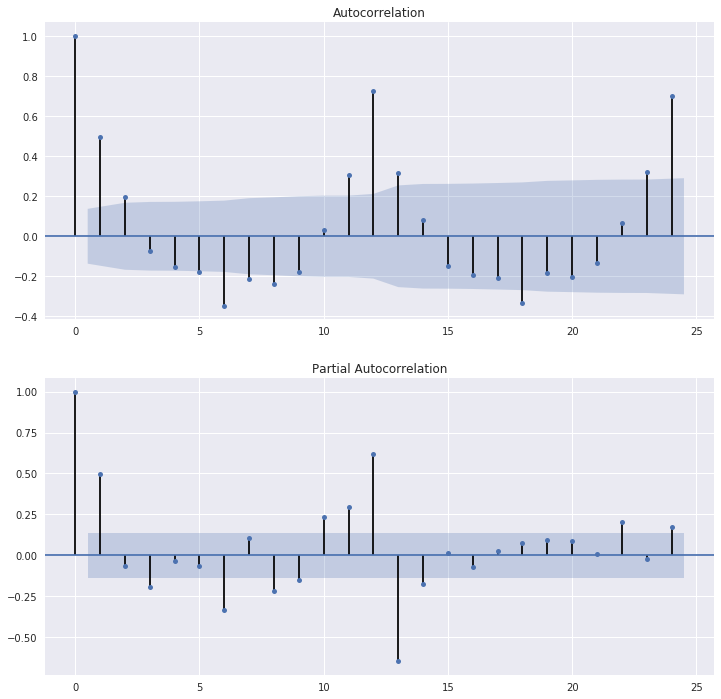

In [36]:
# ACF and PACF plots of the time series data
lag = seasonal_freq * 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(seasonal_series, lags=lag, ax=ax1)
plot_pacf(seasonal_series, lags=lag, ax=ax2)
plt.show()

### 3.e) Test for Stationarity of Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

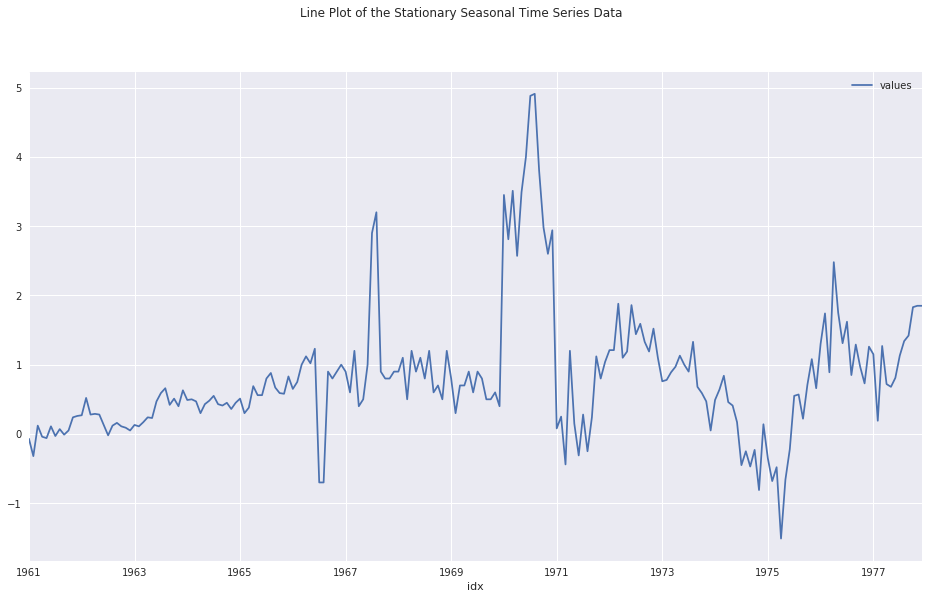

In [37]:
# Create a differenced series
stationary_ss = time_series.diff(seasonal_freq).dropna()

# Plot differenced data
fig, ax = plt.subplots(figsize=(16,9))
fig.suptitle('Line Plot of the Stationary Seasonal Time Series Data')
stationary_ss.plot(ax=ax)
plt.show()

In [38]:
# Check for stationarity
result = adfuller(stationary_ss[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.391473
p-value: 0.144157
Critical Test Statistics Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


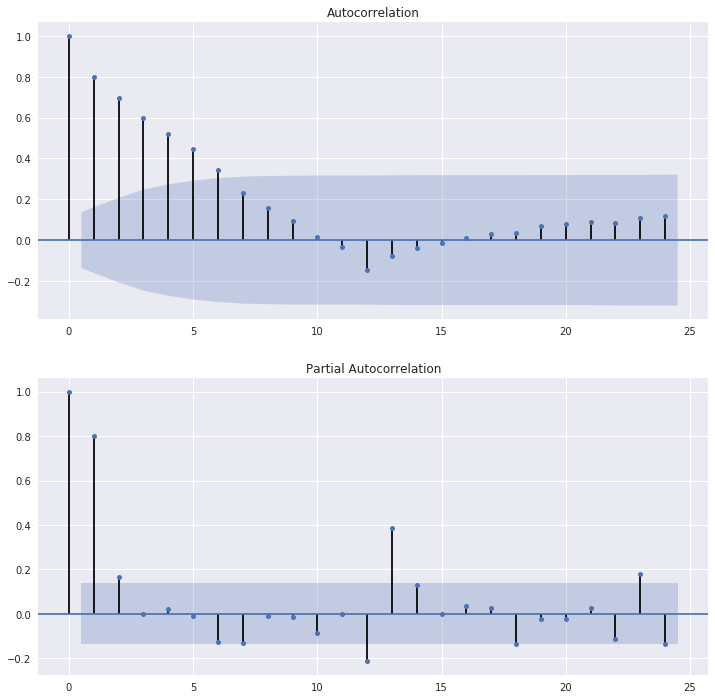

In [39]:
# ACF and PACF plots of the stationary time series
lags = seasonal_freq * 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ss, lags=lags, ax=ax1)
plot_pacf(stationary_ss, lags=lags, ax=ax2)
plt.show()

In [40]:
if (notifyStatus): email_notify("ETS Task 3: Test Data for Trend and Seasonal Factors Completed!"+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4: Fit and Evaluate Models

In [41]:
if (notifyStatus): email_notify("ETS Task 4: Fit and Evaluate Models has begun!"+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [42]:
# Prepare and evaluate a persistence model
data = time_series.values
data = data.astype('float32')
train_pct = 0.80
train_size = int(len(data) * train_pct)
test_size = len(data) - train_size
train_ts, test_ts = data[0:train_size], data[train_size:]

# walk-forward validation
history = [x for x in train_ts]
predictions = list()
for i in range(len(test_ts)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test_ts[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# Calculate performance
rmse = math.sqrt(mean_squared_error(test_ts, predictions))
print('RMSE for the persistent model is: %.3f' % rmse)

>Predicted=13.700, Expected= 14
>Predicted=13.570, Expected= 15
>Predicted=15.120, Expected= 16
>Predicted=15.550, Expected= 17
>Predicted=16.730, Expected= 13
>Predicted=12.680, Expected= 13
>Predicted=12.650, Expected= 11
>Predicted=11.180, Expected= 13
>Predicted=13.270, Expected= 13
>Predicted=12.640, Expected= 11
>Predicted=11.010, Expected= 13
>Predicted=13.300, Expected= 12
>Predicted=12.190, Expected= 13
>Predicted=12.910, Expected= 15
>Predicted=14.900, Expected= 16
>Predicted=16.100, Expected= 17
>Predicted=17.300, Expected= 13
>Predicted=12.900, Expected= 13
>Predicted=13.360, Expected= 12
>Predicted=12.260, Expected= 14
>Predicted=13.930, Expected= 14
>Predicted=13.940, Expected= 13
>Predicted=12.750, Expected= 14
>Predicted=14.190, Expected= 15
>Predicted=14.670, Expected= 15
>Predicted=14.660, Expected= 16
>Predicted=16.210, Expected= 18
>Predicted=17.720, Expected= 18
>Predicted=18.150, Expected= 14
>Predicted=14.190, Expected= 14
>Predicted=14.330, Expected= 13
>Predict

In [43]:
# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,b,r = config
	# define model
	history = np.array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return math.sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul', None]
	p_params = seasonal
	b_params = [True, False]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for b in b_params:
						for r in r_params:
							cfg = [t,d,s,p,b,r]
							models.append(cfg)
	return models

In [44]:
# model configs
cfg_list = exp_smoothing_configs(seasonal=[0,12])
# grid search
print('Model fitting has begun!')
scores = grid_search(data[:,0], cfg_list, test_size)
print('Model fitting completed!')

Model fitting has begun!
 > Model[['add', True, 'add', 12, False, True]] 0.449
 > Model[['add', True, 'add', 12, True, True]] 0.636
 > Model[['add', True, 'add', 12, True, False]] 0.650
 > Model[['add', True, 'add', 12, False, False]] 0.467
 > Model[['add', True, None, 0, False, True]] 5.363
 > Model[['add', True, None, 0, True, True]] 1.716
 > Model[['add', True, None, 0, False, False]] 8.983
 > Model[['add', True, None, 0, True, False]] 1.717
 > Model[['add', True, None, 12, True, True]] 1.716
 > Model[['add', True, None, 12, False, True]] 5.363
 > Model[['add', True, None, 12, False, False]] 8.983
 > Model[['add', True, None, 12, True, False]] 1.717
 > Model[['add', False, 'add', 12, True, True]] 0.601
 > Model[['add', False, 'add', 12, True, False]] 0.602
 > Model[['add', False, 'add', 12, False, True]] 0.453
 > Model[['add', False, 'add', 12, False, False]] 0.454
 > Model[['add', False, 'mul', 12, True, True]] 0.624
 > Model[['add', False, 'mul', 12, True, False]] 0.627
 > Model[[

In [45]:
if (notifyStatus): email_notify("ETS Task 4: Fit and Evaluate Models completed!"+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5: Finalize Model and Make Predictions

In [46]:
if (notifyStatus): email_notify("ETS Task 5: Finalize Model and Make Predictions has begun!"+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [47]:
# list top 3 configs
print('Listing the top three models:')
for cfg, error in scores[:3]:
	print(' > Model[%s] %.3f' % (cfg, error))

Listing the top three models:
 > Model[['add', False, 'mul', 12, False, False]] 0.435
 > Model[['add', False, 'mul', 12, False, True]] 0.436
 > Model[['add', True, 'mul', 12, False, True]] 0.442


In [48]:
if (notifyStatus): email_notify("ETS Task 5: Finalize Model and Make Predictions completed!"+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [49]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:19:34.286456
